<a href="https://colab.research.google.com/github/MuhammadHatta72/pcvk-semester5/blob/main/UAS/UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [24]:
img = cv2.imread('/content/drive/MyDrive/PCVK/UAS/ktms/3D_2141720138_1 - Andhito Galih Nur C.jpg')

img_original = np.copy(img)

# Apply Gaussian Blur
blurred_img = cv2.GaussianBlur(img_original, (5, 5), 0.5)

# Apply Erosion
kernel_erosion = np.ones((3, 3), np.uint8)
eroded_img = cv2.erode(blurred_img, kernel_erosion, iterations=1)

# Apply Dilation
kernel_dilation = np.ones((5, 5), np.uint8)
dilated_img = cv2.dilate(eroded_img, kernel_dilation, iterations=10)

# Apply Opening (Erosion followed by Dilation)
kernel_opening = np.ones((5, 5), np.uint8)
opening_img = cv2.morphologyEx(dilated_img, cv2.MORPH_OPEN, kernel_opening)

gray = cv2.cvtColor(opening_img, cv2.COLOR_BGR2GRAY)

# Otsu Thresholding
_, otsu_thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


In [25]:
# Lokalisasi (Canny)
edged = cv2.Canny(otsu_thresholded, 50, 150)

In [27]:
# Segmentasi

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.015 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
biggest = biggest_contour(contours)
cv2.drawContours(img, [biggest], -1, (0, 255, 0), 3)

# Warp Prespective
points = biggest.reshape(4, 2)
input_points = np.zeros((4, 2), dtype="float32")

points_sum = points.sum(axis=1)
input_points[0] = points[np.argmin(points_sum)]
input_points[3] = points[np.argmax(points_sum)]

points_diff = np.diff(points, axis=1)
input_points[1] = points[np.argmin(points_diff)]
input_points[2] = points[np.argmax(points_diff)]

(top_left, top_right, bottom_right, bottom_left) = input_points
bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

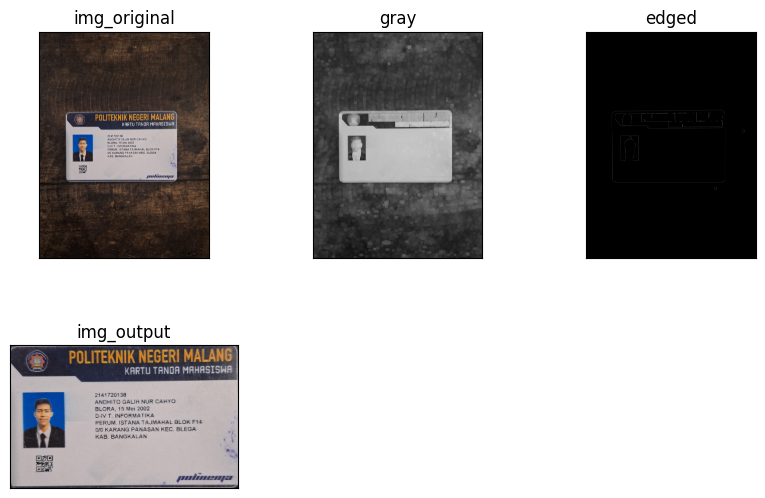

In [6]:
# Output gambar setelah Warp Prespective
ktp_width = 8.6  # Lebar KTP dalam cm
ktp_height = 5.4  # Tinggi KTP dalam cm

max_width = int(ktp_width * 100 / 2.54)
max_height = int(ktp_height * 100 / 2.54)

# Desired points values in the output image
converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

# Perspective transformation
matrix = cv2.getPerspectiveTransform(input_points, converted_points)
img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))

# Visualisasi
titles = ['img_original', 'gray',"edged", "img_output"]
citra2 = [img_original, gray, edged, img_output]

plt.figure(figsize = (10,10))
for i in range(len(citra2)):
  plt.subplot(3,3,i+1),plt.imshow(cv2.cvtColor(citra2[i], cv2.COLOR_BGR2RGB))
  plt.title(titles[i])
  plt.xticks([]),plt.yticks([])

plt.suptitle('', fontsize=16)
plt.show()

In [7]:
cv2.imwrite(f'/content/drive/MyDrive/PCVK/UAS/result_crop/model_3D_2141720138_1 - Andhito Galih Nur C.png', img_output)

True

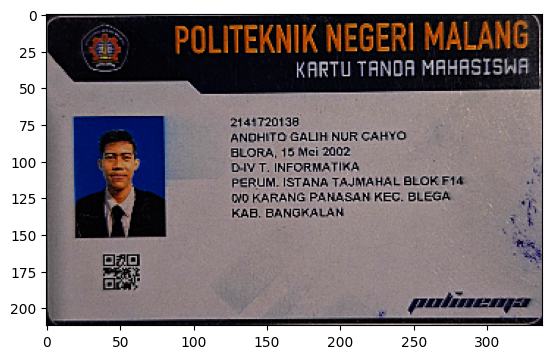

In [8]:
# Tahap Sharpening
def gamma_correction(image, gamma):
    inv_gamma = 1 / gamma
    gamma_image = np.clip((image / 255) ** inv_gamma * 255, 0, 255).astype(np.uint8)
    return gamma_image

def convolution2d(image, kernel):
    return cv2.filter2D(image, -1, kernel)

kernel_sharpen = np.array([[1, 4, 6, 4, 1],
                                [4, 16, 24, 16, 4],
                                [6, 24, -476, 24, 6],
                                [4, 16, 24, 16, 4],
                                [1, 4, 6, 4, 1]], dtype=np.float32) * -1 / 256

result = np.copy(img_output)
ktp_result = gamma_correction(result, 0.5)
ktp_filtered = convolution2d(ktp_result, kernel_sharpen)

plt.imshow(cv2.cvtColor(ktp_filtered, cv2.COLOR_BGR2RGB))
plt.show()

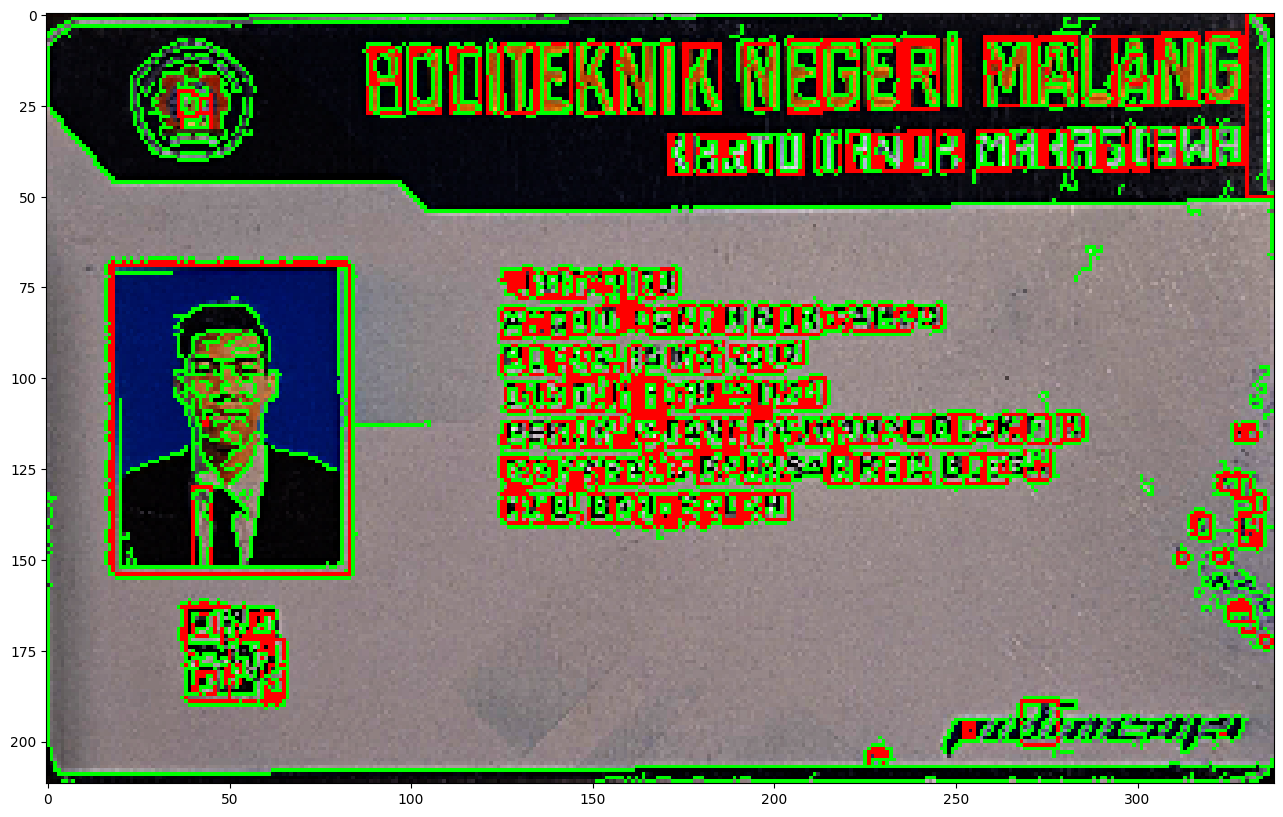

In [22]:
# Load the input image
img = cv2.cvtColor(ktp_filtered, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply edge detection
edges = cv2.Canny(gray, 50, 200, apertureSize=3)

# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours
cv2.drawContours(img, contours, -1, (0, 255, 0), 1)

# Display the input image with the detected contours
plt.figure(figsize=(20,10))
plt.imshow(img)

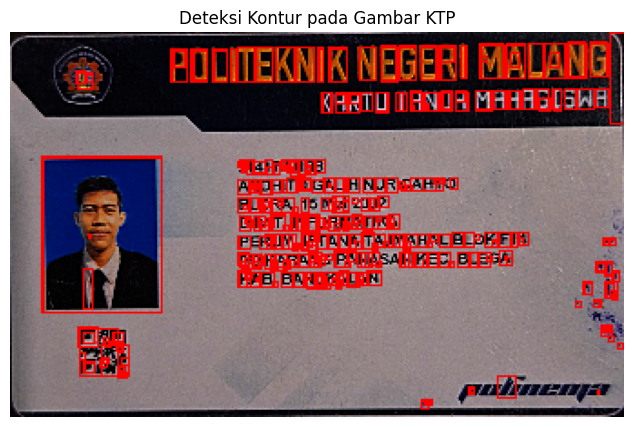

In [20]:
import cv2
import matplotlib.pyplot as plt

# Misalkan ktp_filtered adalah gambar yang telah diolah sebelumnya

# Memfilter gambar dengan Gaussian Blur
blurred = cv2.GaussianBlur(ktp_filtered, (5, 5), 0.5)

# Mengubah gambar ke skala abu-abu
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

# Melakukan thresholding untuk menghasilkan gambar biner
ret, bw = cv2.threshold(gray.copy(), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Melakukan operasi erosi pada gambar biner
erode = cv2.erode(bw.copy(), cv2.getStructuringElement(cv2.MORPH_OPEN, (1, 1)))

# Mengidentifikasi kontur dalam gambar biner
contours, hierarchy = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# Looping kontur yang diidentifikasi untuk menggambar kotak di sekitar kontur yang memenuhi kondisi tertentu
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    ras = format(w / h, '.2f')
    if h >= 4 and w >= 1 and float(ras) <= 1:
        cv2.rectangle(ktp_filtered, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)
    elif h >= 2 and w >= 1 and float(ras) <= 1:
        cv2.rectangle(ktp_filtered, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)

# Menampilkan gambar yang telah dimodifikasi
plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(ktp_filtered, cv2.COLOR_BGR2RGB))
plt.title('Deteksi Kontur pada Gambar KTP')
plt.axis('off')
plt.show()